In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
csv_path = Path("data/RGI2000-v7.0-G-01_alaska-attributes.csv")
df = pd.read_csv(csv_path)
df.head()

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,termlat,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m
0,RGI2000-v7.0-G-01-00001,1,01-01,G204091E67414N,392889,624,2008-09-02T00:00:00,-155.909404,67.413726,5,...,67.416034,1485.3176,1693.6235,1544.6694,1553.9403,17.606613,342.330469,1,COPDEM30,725
1,RGI2000-v7.0-G-01-00002,1,01-01,G204121E67419N,392890,624,2008-09-02T00:00:00,-155.879114,67.419232,5,...,67.421273,1278.4006,1394.7657,1328.5566,1330.9150,19.846369,345.367012,1,COPDEM30,484
2,RGI2000-v7.0-G-01-00003,1,01-01,G204471E67431N,392897,624,2008-09-02T00:00:00,-155.530786,67.431484,5,...,67.435694,1294.7034,1704.7420,1423.2068,1437.2352,23.690063,13.467490,1,COPDEM30,1099
3,RGI2000-v7.0-G-01-00004,1,01-01,G204497E67431N,392899,624,2008-09-02T00:00:00,-155.501948,67.430514,5,...,67.433367,1224.1788,1286.8977,1249.6306,1249.0662,12.782562,42.854332,2,COPDEM30,652
4,RGI2000-v7.0-G-01-00005,1,01-01,G204521E67429N,392901,624,2008-09-02T00:00:00,-155.478173,67.432873,5,...,67.438901,1052.4401,1488.1299,1290.8923,1273.7834,17.148510,299.058193,8,COPDEM30,1903


In [3]:
X_df = df[["aspect_deg", "area_km2", "zmed_m", "zmean_m"]].copy()

# numeric and drop missing variables
X_df = X_df.apply(pd.to_numeric, errors="coerce").dropna()

# log-transform area to reduce skew
X_df = X_df[X_df["area_km2"] > 0]
X_df["area_km2"] = np.log10(X_df["area_km2"])

# convert aspect to sin/cos for PCA validity
X_df["aspect_sin"] = np.sin(np.deg2rad(X_df["aspect_deg"]))
X_df["aspect_cos"] = np.cos(np.deg2rad(X_df["aspect_deg"]))

pca_cols = ["area_km2", "zmed_m", "zmean_m", "aspect_sin", "aspect_cos"]
X_pca = X_df[pca_cols].copy()

X_pca.head()

,area_km2,zmed_m,zmean_m,aspect_sin,aspect_cos
0,-0.621240,1544.6694,1553.9403,-0.303526,0.952823
1,-0.980299,1328.5566,1330.9150,-0.252626,0.967564
2,-0.664331,1423.2068,1437.2352,0.232894,0.972502
3,-0.597483,1249.6306,1249.0662,0.680137,0.733085
4,-0.323566,1290.8923,1273.7834,-0.874127,0.485698


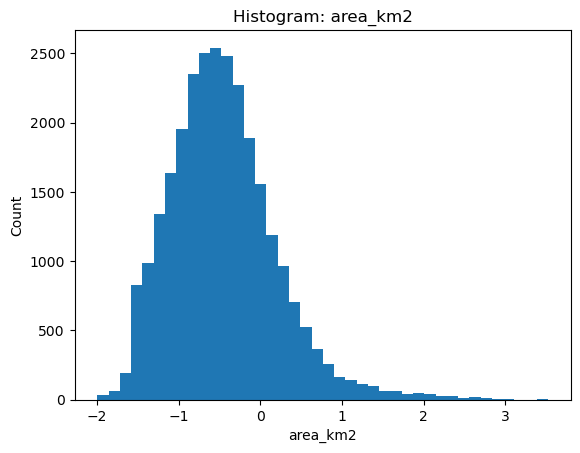

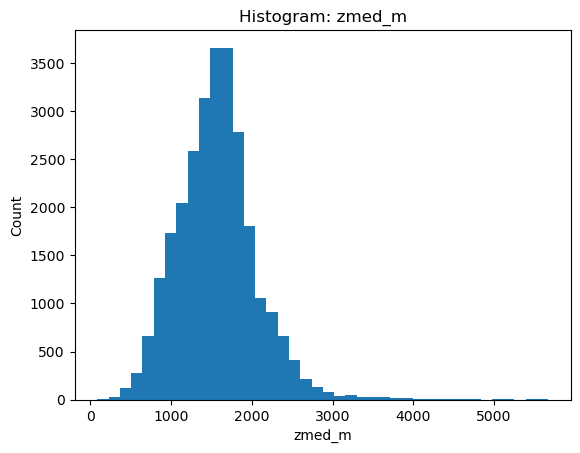

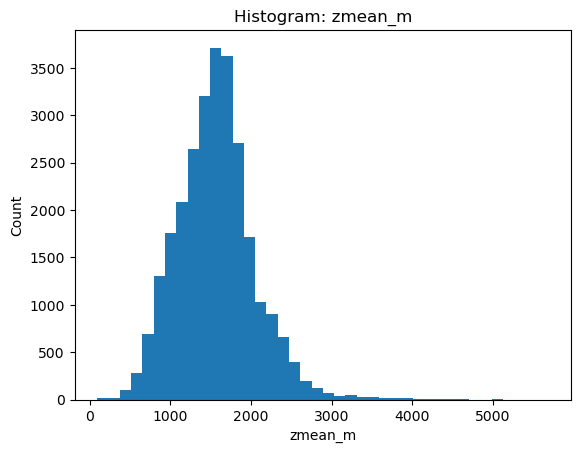

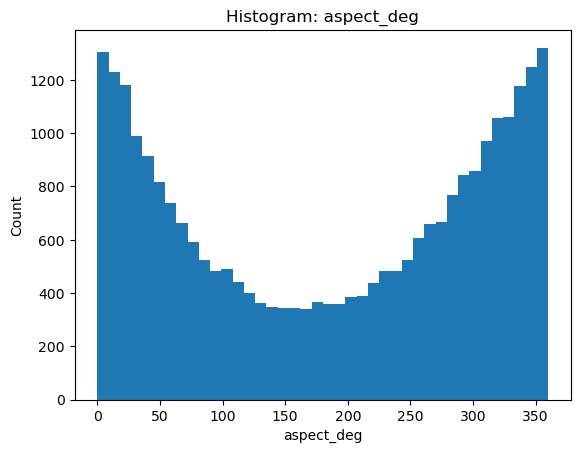

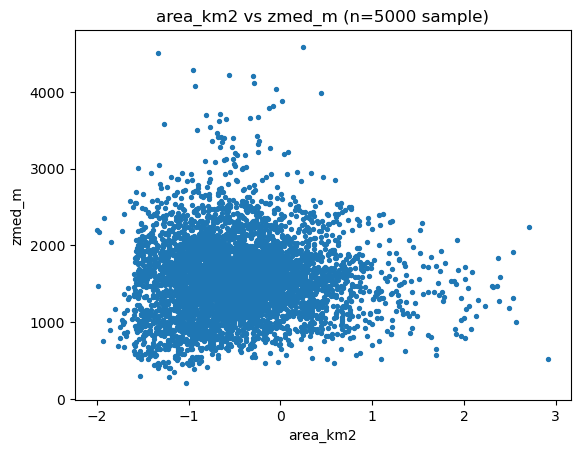

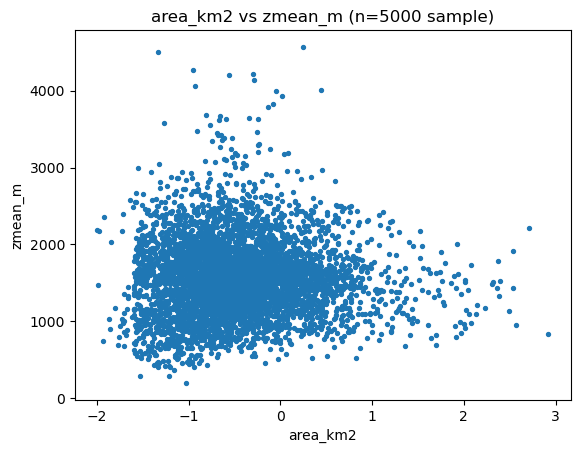

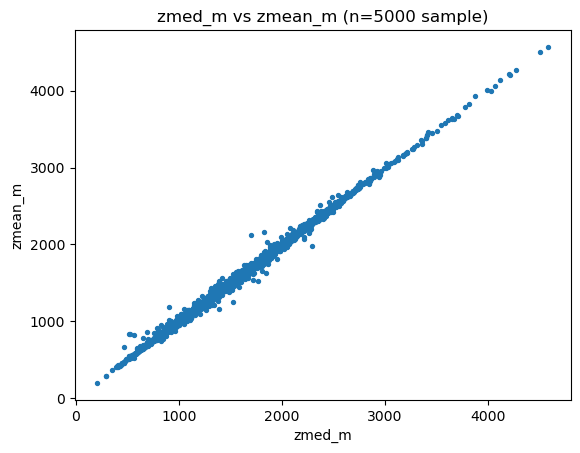

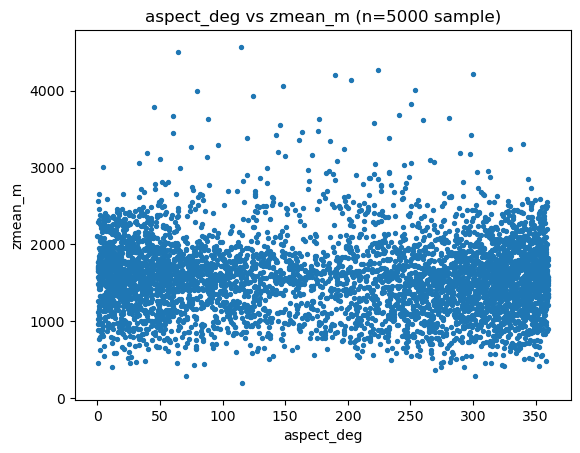

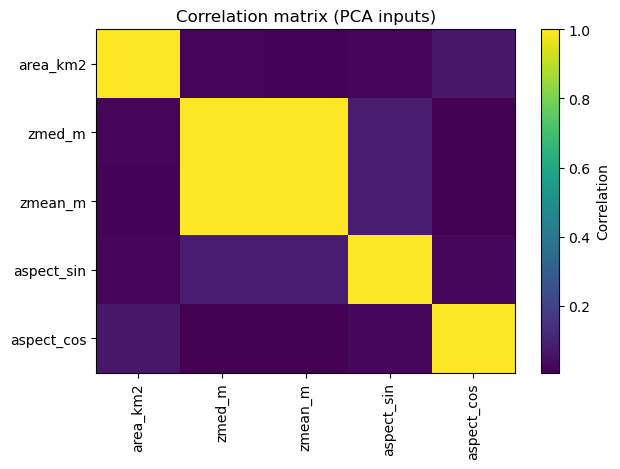

In [4]:
# Histogram
for col in ["area_km2", "zmed_m", "zmean_m", "aspect_deg"]:
    plt.figure()
    plt.hist(X_df[col], bins=40)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Scatterplot
sample = X_df.sample(5000, random_state=42)

pairs = [
    ("area_km2", "zmed_m"),
    ("area_km2", "zmean_m"),
    ("zmed_m", "zmean_m"),
    ("aspect_deg", "zmean_m"),
]

for a, b in pairs:
    plt.figure()
    plt.scatter(sample[a], sample[b], s=8)
    plt.title(f"{a} vs {b} (n=5000 sample)")
    plt.xlabel(a)
    plt.ylabel(b)
    plt.show()

# Correlation heatmap
corr = X_pca.corr()

plt.figure()
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix (PCA inputs)")
plt.tight_layout()
plt.show()

Explained variance ratio: [4.02430270e-01 2.15931792e-01 1.95778352e-01 1.85608236e-01
 2.51348984e-04]
Cumulative explained variance: [0.40243027 0.61836206 0.81414041 0.99974865 1.        ]


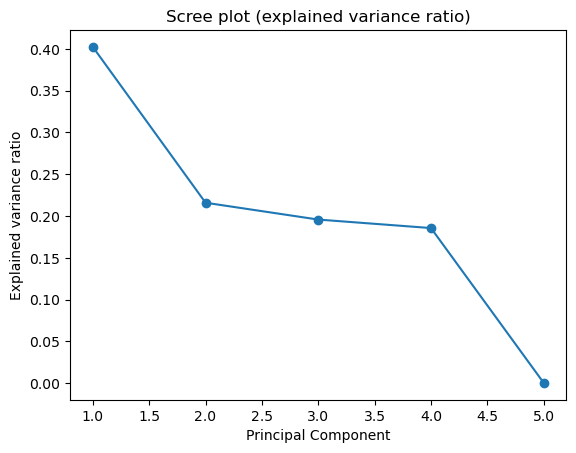

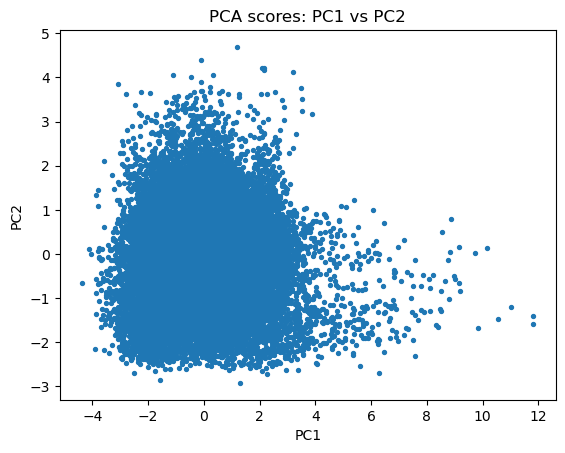

,PC1,PC2,PC3,PC4,PC5
area_km2,0.026097,0.659957,-0.319788,-0.679334,-0.004124
zmed_m,0.702405,-0.041691,-0.068276,0.014330,0.707122
zmean_m,0.702353,-0.044400,-0.066291,0.019346,-0.707078
aspect_sin,0.111610,0.303116,0.935723,-0.141723,0.000226
aspect_cos,0.013749,0.684739,-0.114462,0.719611,0.001079


In [ ]:
X_df = df[["aspect_deg", "area_km2", "zmed_m", "zmean_m"]].copy()
X_df = X_df.apply(pd.to_numeric, errors="coerce").dropna()

# log-transform area to reduce skew
X_df = X_df[X_df["area_km2"] > 0]
X_df["area_km2"] = np.log10(X_df["area_km2"])

# Encode aspect properly for PCA (circular variable)
X_df["aspect_sin"] = np.sin(np.deg2rad(X_df["aspect_deg"]))
X_df["aspect_cos"] = np.cos(np.deg2rad(X_df["aspect_deg"]))

pca_cols = ["area_km2", "zmed_m", "zmean_m", "aspect_sin", "aspect_cos"]
X = X_df[pca_cols].values

# Standardize and fit PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
scores = pca.fit_transform(X_scaled)

# Explained variance
evr = pca.explained_variance_ratio_
print("Explained variance ratio:", evr)
print("Cumulative explained variance:", np.cumsum(evr))

# Scree plot
plt.figure()
plt.plot(range(1, len(evr) + 1), evr, marker="o")
plt.title("Scree plot (explained variance ratio)")
plt.xlabel("Principal Component")
plt.ylabel("Explained variance ratio")
plt.show()

# PC1 vs PC2 scatter
plt.figure()
plt.scatter(scores[:, 0], scores[:, 1], s=8)
plt.title("PCA scores: PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# table that shows how each feature contributes to each PC
loadings = pd.DataFrame(
    pca.components_.T,
    index=pca_cols,
    columns=[f"PC{i}" for i in range(1, len(pca_cols) + 1)]
)
display(loadings)

